# Tutorial: Full Inversion Method for a single chromosome using OpenMiChroM


## This tutorial enables performing Full Inversion Method using Adam 

The first step is to import the OpenMiChroM modules. 

(To install OpenMM and OpenMiChroM, follow the [instalation guide](https://open-michrom.readthedocs.io/en/latest/#))

<font color='red'>Adam optimization is available in OpenMichroM version 1.0.4</font> 

In [1]:
from OpenMiChroM.ChromDynamics import MiChroM # OpenMiChroM simulation module
from OpenMiChroM.Optimization import AdamTraining # Adam optimization module
from OpenMiChroM.CndbTools import cndbTools # Analysis' tools module

# modules to load and plot
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import normalize
import numpy as np
import pandas as pd
import h5py

To create a model trained by the Full Inversion Method using Adam optimization 3 files are required:

1. The experimental Hi-C matrix in text format (dense file) 
2. The sequence file 
3. Initial force field

In the next steps we will create/extract theses files.


*1. Extract the experimental Hi-C matrix*

A Hi-C file is required for the analysis and training of the Full inversion optmization. The file format chosen here is a matrix .txt file (we will call it the dense file).

For this tutorial, we will use chromosome 10 from GM12878 cell line in 100 kb resolution. 

To extract it from the .hic file we can use juicer_tools with this command: 

<code>
java -jar juicer_tools_1.22.01.jar dump observed Balanced -d https://hicfiles.s3.amazonaws.com/hiseq/gm12878/in-situ/combined.hic 10 10 BP 100000 input/chr10_100k.dense
</code>


In [5]:
%%bash
java -jar apps/juicer_tools_1.22.01.jar dump observed Balanced -d https://hicfiles.s3.amazonaws.com/hiseq/gm12878/in-situ/combined.hic 10 10 BP 100000 input/chr10_100k.dense

WARN [2022-09-14T13:46:43,872]  [Globals.java:138] [main]  Development mode is enabled
INFO [2022-09-14T13:46:47,853]  [DirectoryManager.java:179] [main]  IGV Directory: /Users/mm146/igv
INFO [2022-09-14T13:46:48,195]  [HttpUtils.java:937] [main]  Range-byte request succeeded


This command accesses part of the .hic file from the web and extracts the chromosome 10 in .dense format to the folder "input/".

You can get more information about it at the [JuicerTools documentation](https://github.com/aidenlab/juicer/wiki/Juicer-Tools-Quick-Start). 

Visualize the .dense file for inspection

number of beads:  1356


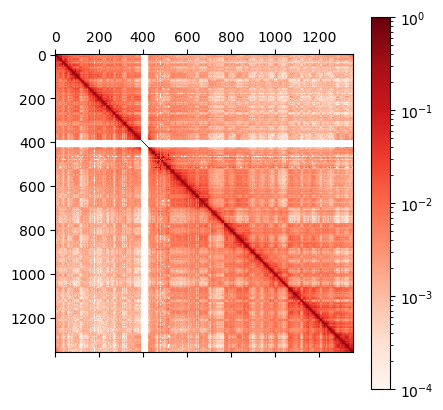

In [6]:
filename = 'input/chr10_100k.dense'
hic_file = np.loadtxt(filename)

r=np.triu(hic_file, k=1) 
r[np.isnan(r)]= 0.0
r = normalize(r, axis=1, norm='max') 
rd = np.transpose(r) 
r=r+rd + np.diag(np.ones(len(r)))
print("number of beads: ", len(r))
plt.matshow(r,norm=mpl.colors.LogNorm(vmin=0.0001, vmax=r.max()),cmap="Reds") 
plt.colorbar()

The Hi-C map has a resolution of 100 kb per bead, so this chromosome 10 model has a polymer chain with a total of 1356 beads.

*2. Create the sequence file*

The second required input is the sequence file. 

The sequence file is a 2 colunms text file that labels each bead of your polymer chain.

In OpenMiChroM, each bead must be assigned a chromatin type. In the full inversion method each pair of interaction is trained individually and therefore each bead is unique. 

To create the sequence file for chr10 (1356 beads) use the following bash command:

In [9]:
%%bash
rm input/seq_chr10
for i in {1..1356}; do echo "$i Bead$i" >> input/seq_chr10; done  

This command creates a file inside the folder "input" named seq_chr10.

The first column is the index for each bead and the second column is the flavor (or type) for each bead. In this tutorial, we chose the names as beadX, where X is the index. You can choose any name for the beads as long as each name is unique. Additionally, you will need to have all names in the force field file (next step).

In [10]:
%%bash
head input/seq_chr10

1 Bead1
2 Bead2
3 Bead3
4 Bead4
5 Bead5
6 Bead6
7 Bead7
8 Bead8
9 Bead9
10 Bead10


*3. Create the initial force field file*

Last but not least, we will create the third required file, the initial force field. The force field is represented by a $N \times N$ matrix, where it pair $(i,j)$ is the interaction between beads $i$ and $j$.

This file format is a csv-file with 1 header line, delimited by comma (",").

To be simple, as a tutorial must be, the initial force field will have all entries equal to $0$.

(In the end of this tutorial, we present a smarter method to fix certain interactions and to solve the centromere problem)

In [11]:
#read the sequence file
seq = np.loadtxt("input/seq_chr10", dtype=str)[:,1]
pol_size = len(seq)
#create a NxN matrix fill with zeros, where N is the chromossome lenght
data = np.zeros((pol_size,pol_size))
#transform it in a Pandas dataframe using the sequence names as header
lamb = pd.DataFrame(data, columns=seq)
#save to a csv file format in the  "input" folder
lamb.to_csv("input/lambda_1", index=False)
lamb

,Bead1,Bead2,Bead3,Bead4,Bead5,Bead6,Bead7,Bead8,Bead9,Bead10,...,Bead1347,Bead1348,Bead1349,Bead1350,Bead1351,Bead1352,Bead1353,Bead1354,Bead1355,Bead1356
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1351,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


With all required files inside the "input" folder, we can start to make iterations to converge the force field. The pipeline for this optimization is the following:  

<img src="apps/pipeline.jpeg" height=300/>  

The next step is to carry out simulations to obtain a contact map from an ensemble of simulated structures. Multiple simulations are required in order to get a converged contact map in each iteration.

Here we will show how to run a single chromosome simulation and run one iteration of the Adam optimization procedure.

To initiate MiChroM, we need to setup some variables:

**time_step=0.01** (the time step used for integration, default is 0.01)<br>
**temperature=1** (set the temperature of your simulation)<br>
**name='opt_chr10_100K'** (the simulation name)<br>

In [36]:
sim = MiChroM(name='opt_chr10_100K',temperature=1.0, time_step=0.01)

    ***************************************************************************************     
     **** **** *** *** *** *** *** *** OpenMiChroM-1.0.4 *** *** *** *** *** *** **** ****      

         OpenMiChroM is a Python library for performing chromatin dynamics simulations.         
                            OpenMiChroM uses the OpenMM Python API,                             
                employing the MiChroM (Minimal Chromatin Model) energy function.                
      The chromatin dynamics simulations generate an ensemble of 3D chromosomal structures      
      that are consistent with experimental Hi-C maps, also allows simulations of a single      
                 or multiple chromosome chain using High-Performance Computing                  
                            in different platforms (GPUs and CPUs).                             
         OpenMiChroM documentation is available at https://open-michrom.readthedocs.io          

         OpenMiChroM is desc

Now we need to setup the platform that we will use. The options are:

**platform="cuda"** (remember that you need to install CUDA in your system)<br>
**GPU="0" (optional)** (if you have more than one GPU device, you can set which gpu you want ["0", "1",...,"n"])<br>
**platform="cpu"**<br>
**platform="opencl"**<br>

In [37]:
sim.setup(platform="opencl")

Set the folder name where the output will be saved

In [38]:
sim.saveFolder('iteration_1')

The next step is to setup your chromosome sequence and the initial configuration

In [39]:
mychro = sim.create_springSpiral(ChromSeq="input/seq_chr10")

Load the initial structure into the "sim" object

In [40]:
sim.loadStructure(mychro, center=True)

Now it is time to include the force field in the simulation object "sim".

Let's separate the forces in two sets:

**Homopolymer Potentials**  

In [41]:
sim.addFENEBonds(kfb=30.0)
sim.addAngles(ka=2.0)
sim.addRepulsiveSoftCore(Ecut=4.0)

**Chromosome Potential**

In this tutorial, we will use the CustomTypes potential. <br>
Here you need to insert the force field file that contains a matrix of interactions for each bead. 
For each iteration of the optimization of the parameters, a new force field file will be created.

To check that, you can look on the documentation https://open-michrom.readthedocs.io/en/latest/OpenMiChroM.html#OpenMiChroM.ChromDynamics.MiChroM.addCustomTypes <br>

In [42]:
sim.addCustomTypes(mu=3.22, rc = 1.78, TypesTable='input/lambda_1')

Note: these values for $mu$ and $r_c$ were calculated for human GM12878 cells and can be changed for other species.

The last potential to be added is the spherical restraint in order to collapse the initial structure

In [43]:
sim.addFlatBottomHarmonic(kr=5*10**-3, n_rad=8.0)

Now we will run a short simulation in order to get a collapsed structure.

There are two variables that control the chromosome simulation steps:

**block:** The number of time steps performed in each cycle (n_blocks)<br>
**n_blocks:** The number of blocks that will be perfomed. <br>

In this example, to perfom the collapse we will run $5\times10^2 \times  10^3 = 5\times10^5$ time steps

In [44]:
block = 5*10**2 
n_blocks = 10**3

We can save the radius of gyration of each block to observe the convergence into the collapsed state (the time required here depends on the size of your chromosome)

In [45]:
rg = []

In [46]:
for _ in range(n_blocks):
    sim.runSimBlock(block, increment=False)
    rg.append(sim.chromRG())

#save the collapsed structure in pdb format for inspection
sim.saveStructure(mode = 'pdb')

Number of exceptions: 1355
adding force  FENEBond 0
adding force  AngleForce 1
Add exclusions for RepulsiveSoftCore force
adding force  RepulsiveSoftCore 2
Add exclusions for CustomTypes force
adding force  CustomTypes 3
adding force  FlatBottomHarmonic 4
Positions... 
 loaded!
potential energy is 31.227320
bl=0 pos[1]=[104.6 -4.8 2.2] dr=1.21 t=0.0ps kin=1.53 pot=31.48 Rg=72.981 SPS=369 
bl=0 pos[1]=[103.6 -3.5 2.8] dr=1.90 t=0.0ps kin=1.69 pot=31.23 Rg=71.762 SPS=1270 
bl=0 pos[1]=[101.9 -2.4 4.3] dr=1.98 t=0.0ps kin=1.78 pot=30.90 Rg=70.345 SPS=1429 
bl=0 pos[1]=[98.9 -0.8 5.7] dr=1.96 t=0.0ps kin=1.83 pot=30.54 Rg=68.884 SPS=1221 
bl=0 pos[1]=[96.1 -0.9 6.9] dr=1.88 t=0.0ps kin=1.76 pot=30.16 Rg=67.447 SPS=1335 
bl=0 pos[1]=[93.9 -1.5 7.3] dr=1.86 t=0.0ps kin=1.81 pot=29.83 Rg=66.033 SPS=1320 
bl=0 pos[1]=[91.7 -1.8 5.9] dr=1.85 t=0.0ps kin=1.85 pot=29.46 Rg=64.602 SPS=1504 
bl=0 pos[1]=[88.3 -1.1 4.7] dr=1.87 t=0.0ps kin=1.86 pot=29.07 Rg=63.184 SPS=1501 
bl=0 pos[1]=[85.9 -1.1 4.

Some details about the output for each performed block:

**bl=0** is the number of each simulated block. In this case we set increment=False, so the number of steps is not being accounted.<br>
**pos\[1\]=\[X,Y,Z\]** is the spatial position for the first bead. <br>
**dr=1.26** shows the average position displacement in each block (in units of sigma). <br>
**t=0** is the total time (?). In this case we set increment=False, so the time is not being increased.<br>
**kin=1.5** is the kinect energy of the system.<br>
**pot=19.90** is the potential energy of the system. <br>
**RG=7.654** is the radius of gyration in the end of each block. <br>
**SPS=12312** is the number of steps per second of each block. A measure of how fast the computations are being performed.

Check the convergence of the radius of gyration:

In [80]:
plt.plot(rg)
plt.xlabel('block number')
plt.ylabel(r'radius of gyration ($\sigma$)')

NameError: name 'rg' is not defined

The next step is to remove the restraining force in order to run the sampling simulation

In [53]:
sim.removeFlatBottomharmonic()

The system does not have FlatBottomHarmonic force.
The forces applied in the system are: dict_keys(['FENEBond', 'AngleForce', 'RepulsiveSoftCore', 'CustomTypes'])



Initiate the Adam optimization object. In this tutorial, this object is named "opt"

In [54]:
opt = AdamTraining(mu=3.22, rc = 1.78, eta=0.01, it=1)

Let's take a look on Adam initialization parameters:

**mu** and **rc** are calculated to fit the experimental Hi-C map. These specific values are for GM12878 (see Di Pierro et al., 2016). <br>
**eta** is the learning rate (default value is 0.01, works well to train the pairwise interactions based on the experimental Hi-C maps)<br>
**it** is the iteration step.

Load the contact matrix file to the object opt

In [55]:
opt.getPars(HiC="input/chr10_100k.dense")

The optimization step uses the contact map from the simulation to update the values in the force field. Therefore, the next step is to perform a long simulation with enough statistics to obtain a converged simulated contact map.<br>

In order to get a good inversion calculation, it is important to have around $1\times10^5$ frames from a set of different simulations. For example, $20$ replicas of $5000$ saved frames. <br> 

This can take some time, so in this tutorial we will use just 1 replica of $5000$ frames saved every $1000$ steps. <br>

$block = 1\times10^3$ <br> 
$n\_blocks = 5000$ 

In [57]:
block = 1000
n_blocks = 50

In [58]:
for _ in range(n_blocks):
    sim.runSimBlock(block, increment=True) #perform 1 block of the simulation
    state = sim.getPositions() #get the positions for each block
    opt.probCalc(state) #calculate and store the contact map for each block

bl=1 pos[1]=[9.5 2.6 6.9] dr=1.90 t=0.0ps kin=1.50 pot=21.55 Rg=11.525 SPS=1003 
bl=2 pos[1]=[11.3 4.8 8.4] dr=1.92 t=0.0ps kin=1.59 pot=21.50 Rg=11.703 SPS=757 
bl=3 pos[1]=[13.3 3.4 8.3] dr=1.93 t=0.0ps kin=1.48 pot=21.53 Rg=11.850 SPS=662 
bl=4 pos[1]=[11.2 5.7 6.7] dr=1.91 t=0.0ps kin=1.54 pot=21.50 Rg=11.965 SPS=737 
bl=5 pos[1]=[8.6 6.0 7.0] dr=1.84 t=0.0ps kin=1.54 pot=21.49 Rg=12.177 SPS=1142 
bl=6 pos[1]=[7.3 3.2 5.5] dr=1.96 t=0.0ps kin=1.60 pot=21.52 Rg=12.340 SPS=1142 
bl=7 pos[1]=[4.8 5.1 8.9] dr=1.89 t=0.0ps kin=1.54 pot=21.51 Rg=12.498 SPS=1130 
bl=8 pos[1]=[5.4 5.7 10.7] dr=1.93 t=0.0ps kin=1.55 pot=21.53 Rg=12.720 SPS=1087 
bl=9 pos[1]=[3.1 4.3 9.2] dr=1.96 t=0.0ps kin=1.53 pot=21.52 Rg=12.803 SPS=923 
bl=10 pos[1]=[5.4 4.3 8.8] dr=1.91 t=0.0ps kin=1.51 pot=21.54 Rg=12.841 SPS=1088 
bl=11 pos[1]=[5.6 4.3 9.0] dr=1.85 t=0.0ps kin=1.46 pot=21.56 Rg=12.786 SPS=1176 
bl=12 pos[1]=[3.4 6.1 8.0] dr=1.91 t=0.0ps kin=1.51 pot=21.55 Rg=12.642 SPS=1118 
bl=13 pos[1]=[2.8 5.4 7.7

In the end of each simulation replica we need to save some important values required to calculate the Adam step. <br>

We save these values using the H5 compressed files because of the efficiency writing/reading them. <br>

<font color='red'>Note: attention to this step. We have two files for each replica for each iteration step. Be organized! </font>

In [59]:
replica=1

with h5py.File(sim.folder + "/Pi_" + str(replica)+".h5", 'w') as hf:
    hf.create_dataset("Pi",  data=opt.Pi)

np.savetxt(sim.folder + "/Nframes_" + str(replica), [opt.NFrames])

The first part of the optimization is finished. Inside the output folder, for each iteration, there are these 2 files used in next step:

Nframes_1<br>
Pi_1.h5

In [60]:
%%bash
ls iteration_1/

Nframes_1
Pi_1.h5
opt_chr10_100K_0_block0.pdb
platform_info.dat
probdist_1


The second part is the inversion. It is quite simple, just feed the optmization object with the files from all replicas and make the inversion to get the updated force field file.

In [61]:
opt2 = AdamTraining(mu=3.22, rc = 1.78, eta=0.01, it=1)
opt2.getPars(HiC="input/chr10_100k.dense")

In [62]:
Nreplicas = 1
path = "iteration_1"
for rep in range(1,Nreplicas+1):
    print("reading files from replica {}".format(rep))
    with h5py.File(path + "/Pi_" + str(rep)+".h5", 'r') as hf:
            opt2.Pi += hf['Pi'][:]
            opt2.NFrames += int(np.loadtxt(path + "/Nframes_" + str(rep)))
    

reading files from replica 1


With the contact probabilities from with all replicas, we calculate the inversion and get the updated parameters for the force field.

To calculate the new FF, we need to load the old one. 

In [63]:
lamb_new = opt2.getLamb(Lambdas="input/lambda_1")

In [64]:
lamb_new

,Bead1,Bead2,Bead3,Bead4,Bead5,Bead6,Bead7,Bead8,Bead9,Bead10,...,Bead1347,Bead1348,Bead1349,Bead1350,Bead1351,Bead1352,Bead1353,Bead1354,Bead1355,Bead1356
0,-0.00999,-0.01000,0.01000,-0.01000,-0.01000,-0.01,-0.01,-0.01,-0.01,-0.01,...,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01000,-0.01000,-0.01000,-0.01000,-0.01000
1,-0.01000,-0.00999,-0.01000,0.01000,-0.01000,-0.01,-0.01,-0.01,-0.01,-0.01,...,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01000,-0.01000,-0.01000,-0.01000,-0.01000
2,0.01000,-0.01000,-0.00999,-0.01000,-0.01000,-0.01,-0.01,-0.01,-0.01,-0.01,...,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01000,-0.01000,-0.01000,-0.01000,-0.01000
3,-0.01000,0.01000,-0.01000,-0.00999,-0.01000,0.01,-0.01,-0.01,-0.01,-0.01,...,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01000,-0.01000,-0.01000,-0.01000,-0.01000
4,-0.01000,-0.01000,-0.01000,-0.01000,-0.00999,-0.01,0.01,-0.01,-0.01,-0.01,...,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01000,-0.01000,-0.01000,-0.01000,-0.01000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1351,-0.01000,-0.01000,-0.01000,-0.01000,-0.01000,-0.01,-0.01,-0.01,-0.01,-0.01,...,-0.01,-0.01,-0.01,0.01,-0.01,-0.00999,-0.01000,0.01000,-0.01000,-0.01000
1352,-0.01000,-0.01000,-0.01000,-0.01000,-0.01000,-0.01,-0.01,-0.01,-0.01,-0.01,...,-0.01,-0.01,-0.01,-0.01,0.01,-0.01000,-0.00999,-0.01000,0.01000,-0.01000
1353,-0.01000,-0.01000,-0.01000,-0.01000,-0.01000,-0.01,-0.01,-0.01,-0.01,-0.01,...,-0.01,-0.01,-0.01,-0.01,-0.01,0.01000,-0.01000,-0.00999,-0.01000,0.01000
1354,-0.01000,-0.01000,-0.01000,-0.01000,-0.01000,-0.01,-0.01,-0.01,-0.01,-0.01,...,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01000,0.01000,-0.01000,-0.00999,-0.01000


Save the new force field to a file. To keep the organization, we use the same name followed by the number of the new iteration:

In [65]:
lamb_new.to_csv("input/lambda_2", index=False)

We can plot the parameters of the force field to check the changes between the 2 steps:

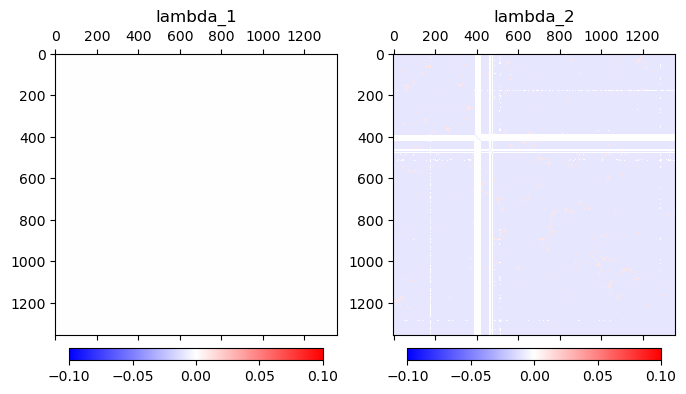

In [67]:
ff_old = pd.read_csv("input/lambda_1")
ff_new = pd.read_csv("input/lambda_2")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

f1 = axes[0].matshow(ff_old.values, vmin=-0.1, vmax=0.1, cmap="bwr")
axes[0].set_title('lambda_1', loc='center')
fig.colorbar(f1, orientation='horizontal', ax=axes[0], shrink=0.9, fraction=0.046, pad=0.04)

f2 = axes[1].matshow(ff_new.values, vmin=-0.1, vmax=0.1, cmap="bwr")
axes[1].set_title('lambda_2', loc='center')
fig.colorbar(f2, orientation='horizontal', ax=axes[1], shrink=0.9, fraction=0.046, pad=0.04)

We can also check the error between experimental and simulation Hi-C maps:

In [68]:
print(opt2.error)

0.9545343908333279


Save/plot the simulation Hi-C and compare to the experimental one

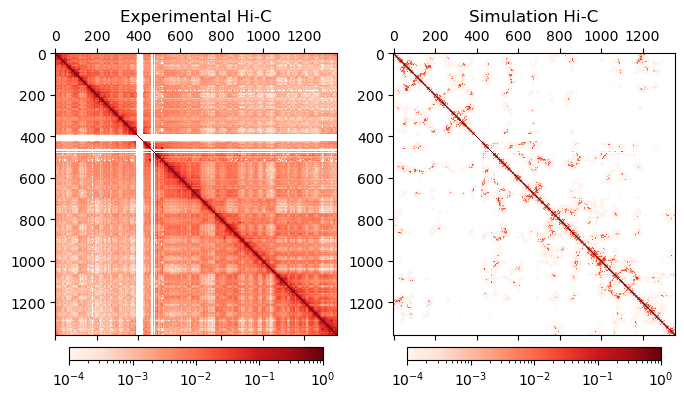

In [69]:
#Save
np.savetxt("iteration_1/probdist_1", opt2.phi_sim)

#Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

f1 = axes[0].matshow(opt2.phi_exp,norm=mpl.colors.LogNorm(vmin=0.0001, vmax=r.max()),cmap="Reds") 
axes[0].set_title('Experimental Hi-C', loc='center')
fig.colorbar(f1, orientation='horizontal', ax=axes[0], shrink=0.9, fraction=0.046, pad=0.04)

f2 = axes[1].matshow(opt2.phi_sim,norm=mpl.colors.LogNorm(vmin=0.0001, vmax=r.max()),cmap="Reds") 
axes[1].set_title('Simulation Hi-C', loc='center')
fig.colorbar(f2, orientation='horizontal', ax=axes[1], shrink=0.9, fraction=0.046, pad=0.04)


As one can see, the simulation Hi-C map is not converged. This is due to two main reasons: </br>
    1 - We just performed a single simulation instead of multiple replicas; </br>
    2 - The force field remains almost with zero interactions due to the number of optimization steps.    

Redo these steps using the new lambda file (lambda_2) as input for customTypes potential in the next iteration. 

## Fixing values on the force field

If we inspect again the experimental Hi-C map you can observe that some regions have a white band. These gaps arise from difficulty of sequencing those regions, often highly repetitive regions. The centromere of the chromosomes is one of them. 

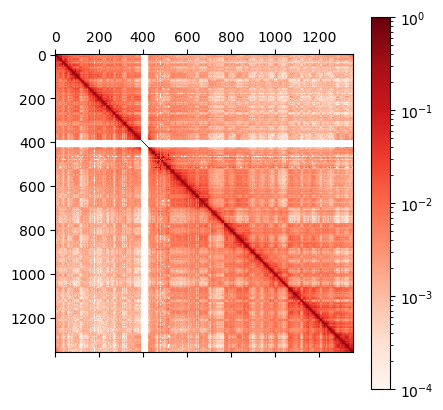

In [70]:
filename = 'input/chr10_100k.dense'
hic_file = np.loadtxt(filename)

r=np.triu(hic_file, k=1) 
r[np.isnan(r)]= 0.0
r = normalize(r, axis=1, norm='max') 
rd = np.transpose(r) 
r=r+rd + np.diag(np.ones(len(r)))
plt.matshow(r,norm=mpl.colors.LogNorm(vmin=0.0001, vmax=r.max()),cmap="Reds") 
plt.colorbar()

So, when we perform the Adam optimization, the parameters regarding the interactions of these regions will not be trained because of the lack of data. 

One way to solve this problem is to define some interactions initially and then keep these fixed over iterations.

Find the index position of each white band 

In [71]:
#get the first diagonal (first neighbor)
diag1 = np.diag(r, k=1)

#find the index where the first neighbor is equal to zero
centromere_index = np.where(diag1 == 0)[0]
print(centromere_index)

[391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408
 409 410 411 412 413 414 415 416 417 418 419 420 421 422 463 464 466 467
 468 477 478 480 481 482 490]


Now we can create the new initial force field parameters' matrix with a specific value for these interactions. Here we chose $-0.3$ for centromere-centromere interactions and $-0.2$ for centromere-other beads.

In [72]:
#read the sequence file
seq = np.loadtxt("input/seq_chr10", dtype=str)[:,1]
pol_size = len(seq)
#create a NxN matrix fill with zeros, where N is the chromossome lenght
data = np.zeros((pol_size,pol_size))

#Set values for centromere regions and NA regions
cent = [391,422]
NAs = [463, 464, 466, 467, 468, 477, 478, 480, 481, 482, 490]
data[cent[0]:cent[1],:] = -0.2
data[:,cent[0]:cent[1]] = -0.2
data[cent[0]:cent[1],cent[0]:cent[1]] = -0.3
for na in NAs:
    data[na,:] = -0.2
    data[:,na] = -0.2

#transform it in a Pandas dataframe using the sequence names as header
lamb = pd.DataFrame(data, columns=seq)
#save to a csv file format in the  "input" folder
lamb.to_csv("input/lambda_fixed_1", index=False)
lamb

,Bead1,Bead2,Bead3,Bead4,Bead5,Bead6,Bead7,Bead8,Bead9,Bead10,...,Bead1347,Bead1348,Bead1349,Bead1350,Bead1351,Bead1352,Bead1353,Bead1354,Bead1355,Bead1356
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1351,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


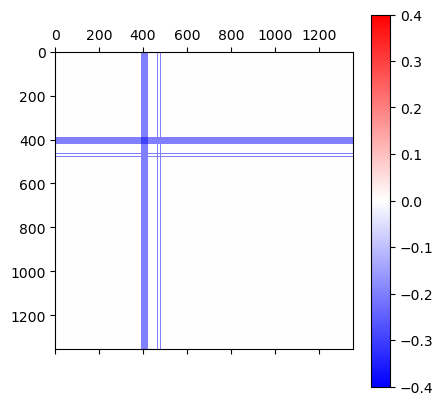

In [73]:
plt.matshow(lamb.values, vmin=-0.4, vmax=0.4, cmap="bwr")
plt.colorbar()

Save the information about the index of the gaps.

When calling the Adam optimization step, we can define fixed points. We provide a list of pair of interactions that will remain unchanged throughout the optimization procedure.

In [74]:
import itertools
#list of all beads
N = np.arange(opt2.expHiC.shape[0])

#use the itertools to create all pair of iteractions
fix_points = list(itertools.product(centromere_index,N))


In [ ]:
#Use the following line to update the parameters maintaining the desired interactions fixed
#lamb_new = opt2.getLamb(Lambdas="input/lambda_1", fixedPoints=fix_points)

We included a folder named "scripts" that has some .py and .slurm files that can be used to run this optimization in parallel using slurm clusters. 